# Модель нейронной сети
##  Автор: Луттиев Владислав, Учебная группа: о.ИЗДтс 23.2/Б3-22


In [1]:
# Импорт библиотек

import os
import random
import numpy as np
import pandas as pd
import time
from tqdm import tqdm

# PyTorch
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

# Sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report,
)

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Загрузка набора данных

paths = {
    'train': 'nn-dataset/leads_train_nn.csv',
    'val': 'nn-dataset/leads_val_nn.csv',
    'test': 'nn-dataset/leads_test_nn.csv',
}

# Проверка существования файлов
missing = [p for p in paths.values() if not os.path.exists(p)]
if missing:
    raise FileNotFoundError(f'Не найден {missing}.')

train_df = pd.read_csv(paths['train'])
val_df = pd.read_csv(paths['val'])
test_df = pd.read_csv(paths['test'])

# Проверка целевой переменной
target_col = 'Converted'
feature_cols = [c for c in train_df.columns if c != target_col]

auth_cols = set(train_df.columns)
for name, df in [('val', val_df), ('test', test_df)]:
    if set(df.columns) != auth_cols:
        diff = auth_cols ^ set(df.columns)
        raise ValueError(f'Несоответствие столбцов для {name}: {diff}')

print('Train:', train_df.shape, 'Val:', val_df.shape, 'Test:', test_df.shape)


Train: (5383, 172) Val: (1154, 172) Test: (1154, 172)


In [3]:
# Фиксируем генераторы случайных чисел

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [4]:
# Устройство нейронной сети
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [5]:
# Подготовка и масштабирование признаков

num_cols = [c for c in feature_cols if c.startswith('num__')]
scaler = StandardScaler()

# Масштабирование
if num_cols:
    train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
    val_df[num_cols] = scaler.transform(val_df[num_cols])
    test_df[num_cols] = scaler.transform(test_df[num_cols])

# Преобразование
def to_arrays(df):
    X = df[feature_cols].to_numpy(dtype=np.float32)
    y = df[target_col].astype(np.float32).to_numpy()
    return X, y


X_train, y_train = to_arrays(train_df)
X_val, y_val = to_arrays(val_df)
X_test, y_test = to_arrays(test_df)

print('Размер входного слоя нейронной сети:', X_train.shape[1], '| Масштабированных числовых признаков:', len(num_cols))


Размер входного слоя нейронной сети: 171 | Масштабированных числовых признаков: 6


In [6]:
# Создание набора данных
class LeadDataset(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = None if y is None else torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        if self.y is None:
            return self.X[idx]
        return self.X[idx], self.y[idx]

batch_size = 256
# Создание
train_ds = LeadDataset(X_train, y_train)
val_ds   = LeadDataset(X_val, y_val)
test_ds  = LeadDataset(X_test, y_test)

# Зазрузчик
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)


In [7]:
# Создание примерной модели нейронной сети, на вход подается 

class LeadMLP(nn.Module):
    def __init__(self, input_layer):
        super().__init__() # Инициализация базового класса nn.Module
        
        # Архитектура сети
        self.net = nn.Sequential(
            nn.Linear(input_layer, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )
    def forward(self, x):
        return self.net(x).squeeze(1)


In [8]:
# Инициализируем модель, функции потерь и оптимизатора
model = LeadMLP(X_train.shape[1]).to(device)
# Расчёт веса положительного класса
pos_weight_value = (len(y_train) - y_train.sum()) / y_train.sum()
# Функция потерь
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight_value], device=device))
# Оптимизатор
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [9]:
# Cтруктура модели
print("Model Summary...\n")
summary(model, input_size=(X_train.shape[1],))

Model Summary...

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]          44,032
       BatchNorm1d-2                  [-1, 256]             512
              ReLU-3                  [-1, 256]               0
           Dropout-4                  [-1, 256]               0
            Linear-5                  [-1, 128]          32,896
       BatchNorm1d-6                  [-1, 128]             256
              ReLU-7                  [-1, 128]               0
           Dropout-8                  [-1, 128]               0
            Linear-9                   [-1, 64]           8,256
             ReLU-10                   [-1, 64]               0
          Dropout-11                   [-1, 64]               0
           Linear-12                    [-1, 1]              65
Total params: 86,017
Trainable params: 86,017
Non-trainable params: 0
---------------

In [10]:
# Обучение модели
# Колличество эпох
num_epochs = 50
patience = 8

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_loss = float('inf')
best_val_acc = 0.0
best_epoch = 0
no_improve = 0

best_model_path = "model.pt"
last_model_path = "model_last.pt"

model.to(device)

# Подсчет времени обучения
start_time = time.time()

for epoch in range(1, num_epochs + 1):
    # Обучение модели
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    train_loop = tqdm(
        train_loader,
        desc=f"Эпоха {epoch}/{num_epochs} — обучение",
        leave=True,
        ncols=80
    )

    for xb, yb in train_loop:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * yb.size(0)
        preds = (torch.sigmoid(logits) >= 0.5).float()
        correct_train += (preds == yb).sum().item()
        total_train += yb.size(0)

        train_loop.set_postfix(loss=loss.item())

    epoch_train_loss = running_loss / total_train
    epoch_train_acc = correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)

    # Валидация модели
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0

    val_loop = tqdm(
        val_loader,
        desc=f"Эпоха {epoch}/{num_epochs} — валидация",
        leave=True,
        ncols=80
    )

    with torch.no_grad():
        for xb, yb in val_loop:
            xb, yb = xb.to(device), yb.to(device)

            logits = model(xb)
            loss = criterion(logits, yb)

            val_running_loss += loss.item() * yb.size(0)
            preds = (torch.sigmoid(logits) >= 0.5).float()
            correct_val += (preds == yb).sum().item()
            total_val += yb.size(0)

    epoch_val_loss = val_running_loss / total_val
    epoch_val_acc = correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)

    # Вывод результатов
    print(
        f"Эпоха [{epoch}/{num_epochs}], "
        f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_acc*100:.2f}%, "
        f"Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_acc*100:.2f}%"
    )

    # Сохранение лучшей модели
    improved = epoch_val_loss < best_val_loss - 1e-4
    if improved:
        best_val_loss = epoch_val_loss
        best_val_acc = epoch_val_acc
        best_epoch = epoch
        no_improve = 0
        torch.save(model.state_dict(), best_model_path)
        print("Лучшая модель сохранена")

    else:
        no_improve += 1

    # Сохранение последней эпохи
    torch.save(model.state_dict(), last_model_path)

    if no_improve >= patience:
        print(f"Раннее прекращение обучения на эпохе {epoch} (лучшая — {best_epoch})")
        break

end_time = time.time()
total_time = end_time - start_time
print("\nОбучение завершено.")
print(f"Лучший Val Loss: {best_val_loss:.4f}, Val Acc: {best_val_acc*100:.2f}% на эпохе {best_epoch}")
print(f"Время обучения: {total_time/60:.2f} минут ({total_time:.1f} секунд)")


Эпоха 1/50 — валидация: 100%|████████████████████| 5/5 [00:00<00:00, 477.86it/s]


Эпоха [1/50], Train Loss: 0.5875, Train Accuracy: 79.01%, Val Loss: 0.4641, Val Accuracy: 87.52%
Лучшая модель сохранена


Эпоха 2/50 — валидация: 100%|████████████████████| 5/5 [00:00<00:00, 475.51it/s]


Эпоха [2/50], Train Loss: 0.3013, Train Accuracy: 90.41%, Val Loss: 0.2697, Val Accuracy: 90.99%
Лучшая модель сохранена


Эпоха 3/50 — валидация: 100%|████████████████████| 5/5 [00:00<00:00, 553.59it/s]


Эпоха [3/50], Train Loss: 0.2339, Train Accuracy: 93.05%, Val Loss: 0.2508, Val Accuracy: 92.20%
Лучшая модель сохранена


Эпоха 4/50 — валидация: 100%|████████████████████| 5/5 [00:00<00:00, 494.75it/s]


Эпоха [4/50], Train Loss: 0.2170, Train Accuracy: 93.37%, Val Loss: 0.2457, Val Accuracy: 91.94%
Лучшая модель сохранена


Эпоха 5/50 — валидация: 100%|████████████████████| 5/5 [00:00<00:00, 477.95it/s]


Эпоха [5/50], Train Loss: 0.2040, Train Accuracy: 94.06%, Val Loss: 0.2457, Val Accuracy: 91.51%


Эпоха 6/50 — валидация: 100%|████████████████████| 5/5 [00:00<00:00, 437.03it/s]


Эпоха [6/50], Train Loss: 0.2079, Train Accuracy: 94.17%, Val Loss: 0.2389, Val Accuracy: 91.25%
Лучшая модель сохранена


Эпоха 7/50 — валидация: 100%|████████████████████| 5/5 [00:00<00:00, 533.44it/s]


Эпоха [7/50], Train Loss: 0.1972, Train Accuracy: 94.32%, Val Loss: 0.2394, Val Accuracy: 92.29%


Эпоха 8/50 — валидация: 100%|████████████████████| 5/5 [00:00<00:00, 556.84it/s]


Эпоха [8/50], Train Loss: 0.1782, Train Accuracy: 94.43%, Val Loss: 0.2359, Val Accuracy: 91.68%
Лучшая модель сохранена


Эпоха 9/50 — валидация: 100%|████████████████████| 5/5 [00:00<00:00, 539.92it/s]


Эпоха [9/50], Train Loss: 0.1847, Train Accuracy: 94.52%, Val Loss: 0.2390, Val Accuracy: 91.77%


Эпоха 10/50 — валидация: 100%|███████████████████| 5/5 [00:00<00:00, 540.56it/s]


Эпоха [10/50], Train Loss: 0.1759, Train Accuracy: 94.59%, Val Loss: 0.2379, Val Accuracy: 92.03%


Эпоха 11/50 — валидация: 100%|███████████████████| 5/5 [00:00<00:00, 561.37it/s]


Эпоха [11/50], Train Loss: 0.1691, Train Accuracy: 95.06%, Val Loss: 0.2346, Val Accuracy: 91.94%
Лучшая модель сохранена


Эпоха 12/50 — валидация: 100%|███████████████████| 5/5 [00:00<00:00, 510.47it/s]


Эпоха [12/50], Train Loss: 0.1714, Train Accuracy: 94.74%, Val Loss: 0.2359, Val Accuracy: 91.77%


Эпоха 13/50 — валидация: 100%|███████████████████| 5/5 [00:00<00:00, 517.92it/s]


Эпоха [13/50], Train Loss: 0.1666, Train Accuracy: 95.13%, Val Loss: 0.2341, Val Accuracy: 91.94%
Лучшая модель сохранена


Эпоха 14/50 — валидация: 100%|███████████████████| 5/5 [00:00<00:00, 535.63it/s]


Эпоха [14/50], Train Loss: 0.1647, Train Accuracy: 95.17%, Val Loss: 0.2445, Val Accuracy: 91.42%


Эпоха 15/50 — валидация: 100%|███████████████████| 5/5 [00:00<00:00, 518.80it/s]


Эпоха [15/50], Train Loss: 0.1589, Train Accuracy: 95.15%, Val Loss: 0.2340, Val Accuracy: 92.03%


Эпоха 16/50 — валидация: 100%|███████████████████| 5/5 [00:00<00:00, 527.98it/s]


Эпоха [16/50], Train Loss: 0.1616, Train Accuracy: 95.24%, Val Loss: 0.2397, Val Accuracy: 91.85%


Эпоха 17/50 — валидация: 100%|███████████████████| 5/5 [00:00<00:00, 467.99it/s]


Эпоха [17/50], Train Loss: 0.1579, Train Accuracy: 95.30%, Val Loss: 0.2456, Val Accuracy: 91.94%


Эпоха 18/50 — валидация: 100%|███████████████████| 5/5 [00:00<00:00, 470.47it/s]


Эпоха [18/50], Train Loss: 0.1574, Train Accuracy: 95.11%, Val Loss: 0.2415, Val Accuracy: 91.85%


Эпоха 19/50 — валидация: 100%|███████████████████| 5/5 [00:00<00:00, 493.82it/s]


Эпоха [19/50], Train Loss: 0.1559, Train Accuracy: 95.02%, Val Loss: 0.2446, Val Accuracy: 92.20%


Эпоха 20/50 — валидация: 100%|███████████████████| 5/5 [00:00<00:00, 488.80it/s]


Эпоха [20/50], Train Loss: 0.1398, Train Accuracy: 95.91%, Val Loss: 0.2477, Val Accuracy: 91.85%


Эпоха 21/50 — валидация: 100%|███████████████████| 5/5 [00:00<00:00, 428.04it/s]

Эпоха [21/50], Train Loss: 0.1406, Train Accuracy: 95.43%, Val Loss: 0.2537, Val Accuracy: 92.55%
Раннее прекращение обучения на эпохе 21 (лучшая — 13)

Обучение завершено.
Лучший Val Loss: 0.2341, Val Acc: 91.94% на эпохе 13
Время обучения: 0.04 минут (2.6 секунд)


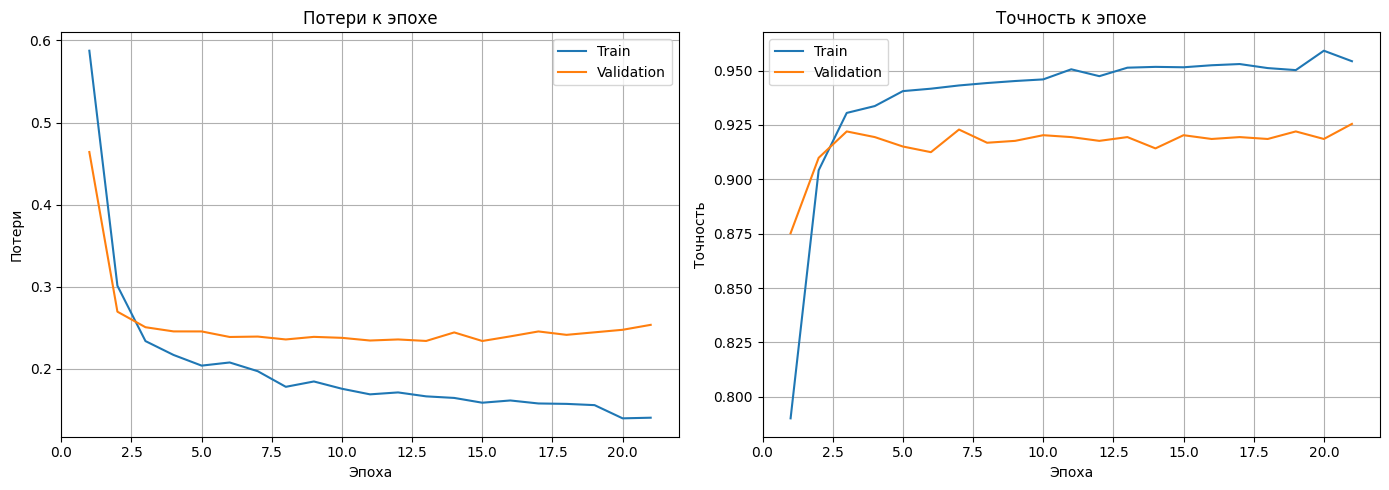

In [11]:
# Визуализация обучения
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 5))

# График потерь
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train')
plt.plot(epochs, val_losses, label='Validation')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.title('Потери к эпохе')
plt.legend()
plt.grid(True)

# График точности
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train')
plt.plot(epochs, val_accuracies, label='Validation')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.title('Точность к эпохе')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
